## 0.0 Python library設定

In [1]:
import sys
import cntk as C
import numpy as np
from numpy.random import rand, randint #For selecting samples
import matplotlib.pyplot as plt

np.random.seed(0) #For reproductivity

## 1.0 データ生成

ここでは、`CNTK`で`線型回帰`(単回帰)を扱います.

- 説明変数 $x$ (feature)：$0+r \sim 10000+r$
- 目的変数 $y$ (label)：関係式: $y=2x+r$

但し $r$ は $0$ ～ $1$までのランダムノイズ

まとめると、

|変数|内容|範囲|
|:--|:--:|:--:|
|$x$|説明変数|$0 \sim 10000$ + ランダムノイズ|
|$y$|目的変数|$0 \sim 20000$ + ランダムノイズ|

In [2]:
# サンプル数
total_sample_size = 10000

# データ生成
# "resyape"は後でTrainingの引数に合わせるため
features = np.array([i + rand() for i in range(total_sample_size)], dtype=np.float32).reshape(total_sample_size, 1)
labels = np.array([2*i + rand() for i in range(total_sample_size)], dtype=np.float32).reshape(total_sample_size, 1)

幾つか数を取り出してみます

In [3]:
print("original : 0          1         2         3         4")
print("           ↓        ↓         ↓        ↓        ↓")
print("features :", features[0:5,:].T[0])
print("labels   :", labels[0:5,:].T[0])

original : 0          1         2         3         4
           ↓        ↓         ↓        ↓        ↓
features : [0.5488135 1.7151893 2.6027634 3.5448833 4.423655 ]
labels   : [0.748268  2.1802027 4.3890233 6.0376    8.011787 ]


In [4]:
# 生成データから、サンプル数を指定して抽出する関数を作っておきます
def generate_random_data_sample(total_sample_size, sample_size, features, labels):
    '''
    引数
        total_sample_size: サンプル総数
        sample_size: 抽出サンプル数
        features: 説明変数データソース
        labels: 目的変数データソース
        
    Return
        features, labels
    '''
    # 何番目のデータを取り出すか
    index = randint(0, total_sample_size, sample_size)
    # データ抽出
    return features[index, :], labels[index, :]

## 1.2 全データをTraining, Testに分割

全$10,000$件のデータを$0$～$9,000$番目までをTraining,残り1,000件をTestに用います.

Training : Test = 9 : 1

In [5]:
split_threshold = 9000

train_features, train_labels, test_features, test_labels = \
    features[:split_threshold], labels[:split_threshold], features[split_threshold:], labels[split_threshold:]

## 1.3 内容を可視化

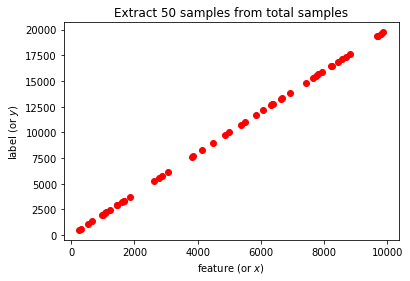

In [6]:
# 先ほど作った関数 generate_random_data_sample を使ってランダムに50件を抽出
features_sample, labels_sample = generate_random_data_sample( 
    total_sample_size=total_sample_size, 
    sample_size=50, 
    features=features, 
    labels=labels)

# 可視化
plt.scatter(features_sample, labels_sample, c='r')
plt.xlabel("feature (or $x$)")
plt.ylabel("label (or $y$)")
plt.title("Extract 50 samples from total samples")
plt.show()

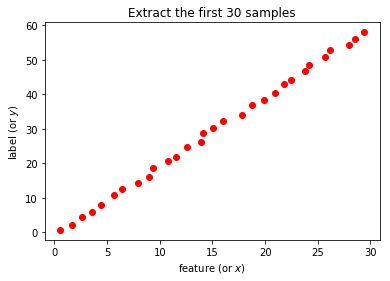

In [7]:
# 最初の30件を抽出 & 可視化
plt.scatter(features[0:30], labels[0:30], c='r')
plt.xlabel("feature (or $x$)")
plt.ylabel("label (or $y$)")
plt.title("Extract the first 30 samples")
plt.show()

## 2.0 モデル構造を定義

- 入力・出力変数ともに、次元は$1$
- 入力・出力変数の関係を$y = Wx + b$と仮定して、$W$, $b$を求めることにします。

|変数名|内容|
|:--:|:--|
|$x$|説明変数|
|$y$|目的変数|
|$W$|Weight|
|$b$|bias|

In [8]:
# 入力変数を定義(activation関数なし)
input_dim = 1
num_outputs = 1
input = C.input_variable(input_dim, np.float32)
label = C.input_variable(num_outputs, np.float32)

Training procedure means adjusting parameters $W$, $b$, and we'll use `parameter` method in CNTK:

In [9]:
# 関数を定義
# mydictは、後でW, bの軌跡を確認するための入れ物
mydict = {}
def linear_layer(input_var, output_dim):
    input_dim = input_var.shape[0]
    # Weight Wを定義
    weight_param = C.parameter(shape=(input_dim, output_dim))
    # Bias bを定義
    bias_param = C.parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] = weight_param, bias_param

    # Wx + b. 変数の順序に注意！
    return bias_param + C.times(input_var, weight_param)

$z$ は、パラメータ$W$, $b$を使った推定値(予測値)を入れるための変数

In [10]:
# モデル構造を定義(linear_layerは先ほど作成した関数)
z = linear_layer(input, num_outputs)

## 2.1 損失関数(`loss`, `eval_error`)の定義

- `loss` ：学習時に利用
- `eval_error` ：評価時に利用 

今回は、回帰モデルを使っており、同じ評価関数(二乗誤差:`C.squared_error`)を利用.

In [11]:
# Setup loss and evaluation functions
loss = C.squared_error(z, label)
eval_error = C.squared_error(z, label)

## 2.2 Training用パラメータを設定

- `learning_rate`：どの程度の速さで学習を進めるかを定義（学習率）。小さすぎると収束が遅いし、大きすぎるとそもそも収束しない 

- `lr_schedule` ：学習の進み具合を定義。今回は`learning_rate`の幅で一定間隔で学習を進める

In [12]:
# Learning rateを定義
learning_rate = 0.0000000001
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.sample) 

## 2.3 `learner`(どう最適化するか=誤差を縮めるか)の定義

- `learner`：パラメータをどう最適化するか、を定義
    - `sgd`: 最適化アルゴリズムのSGD(確率的勾配降下法)を利用
    - `z.parameters`: 調整すべきパラメータの指定（`W`, `b`）
    - `lr_schedule`: 学習率スケジュール

In [13]:
learner = C.sgd(z.parameters, lr_schedule)

- `trainer`: 今まで定義してきた損失関数、誤差関数、最適化方法などをまとめて定義

In [14]:
trainer = C.Trainer(z, (loss, eval_error), [learner])

## 2.4 進捗度表示関数(`progress printer`)を定義(option)

通常、深層学習は学習時間が長いため、学習の途中の状況を確認することが一般的.

（でないと、例えば学習に数日かかって、凡ミスに気づいて再実行、、なんてことが、、、）

In [15]:
# Define a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))

    return mb, training_loss, eval_error

In [16]:
# 最適化実行問のパラメータ
minibatch_size = 50 ## 1度の最適化で投入するサンプル数
num_samples_to_train = split_threshold ## Trainingに利用する全サンプル数
num_minibatches_to_train = int(num_samples_to_train / minibatch_size) ## 

# Run the trainer and perform model training
training_progress_output_freq = 10

In [17]:
W_values, b_values = [], []

# Training process
for i in range(0, num_minibatches_to_train):
    # Extract training data
    feature_samples, label_samples = generate_random_data_sample(
        total_sample_size=split_threshold
        ,sample_size=minibatch_size
        ,features=train_features 
        ,labels=train_labels)
    
    # Train
    trainer.train_minibatch({input : feature_samples, label : label_samples})
    # Progress print(進捗確認: option)

    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)

    # W, bの値を保存
    W_values.append(mydict['w'].value)
    b_values.append(mydict['b'].value)

Minibatch: 0, Loss: 92605081.6000, Error: 92605081.60
Minibatch: 10, Loss: 196458.1400, Error: 196458.14
Minibatch: 20, Loss: 171.2585, Error: 171.26
Minibatch: 30, Loss: 0.9980, Error: 1.00
Minibatch: 40, Loss: 0.4400, Error: 0.44
Minibatch: 50, Loss: 0.5868, Error: 0.59
Minibatch: 60, Loss: 0.4837, Error: 0.48
Minibatch: 70, Loss: 0.4981, Error: 0.50
Minibatch: 80, Loss: 0.4600, Error: 0.46
Minibatch: 90, Loss: 0.4628, Error: 0.46
Minibatch: 100, Loss: 0.6381, Error: 0.64
Minibatch: 110, Loss: 0.3336, Error: 0.33
Minibatch: 120, Loss: 0.5066, Error: 0.51
Minibatch: 130, Loss: 0.5030, Error: 0.50
Minibatch: 140, Loss: 0.4732, Error: 0.47
Minibatch: 150, Loss: 0.4439, Error: 0.44
Minibatch: 160, Loss: 0.3957, Error: 0.40
Minibatch: 170, Loss: 0.4277, Error: 0.43


## 3.0 Confirm final parameter set

In [18]:
print("pre-defined weight: 2,  adjusted weight: ", mydict['w'].value[0][0])
print("pre-defined bias  : 1,  adjusted bias  : ", mydict['b'].value[0])

pre-defined weight: 2,  adjusted weight:  1.9999267
pre-defined bias  : 1,  adjusted bias  :  0.0003381935


## 3.1 Confirm how the parameters converge

We find that weight $W$ converges into $2$, but the convergence of bias $b$ to $1$ is very slow in the following plot:

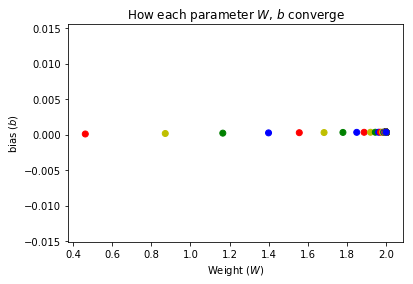

In [19]:
plt.scatter(W_values, b_values, c='rygb')
plt.xlabel('Weight ($W$)')
plt.ylabel('bias ($b$)')
plt.title('How each parameter $W$, $b$ converge')
plt.show()

## 4.0 評価(`.eval`)

In [20]:
# 評価関数にevalメソッドを利用
result = z.eval({input : test_features})

In [21]:
SAMPLE_NUM = 7
print("        Features:", test_features[:SAMPLE_NUM].T[0])
print("   Actual values:", test_labels[:SAMPLE_NUM].T[0])
print("Predicted values:", result[:SAMPLE_NUM].T[0], "\n")
print("           Error:", [(test-result)[0] for test, result in zip(test_labels, result)][:SAMPLE_NUM])

        Features: [9000.637 9001.9   9002.774 9003.129 9004.066 9005.942 9006.161]
   Actual values: [18000.459 18002.74  18004.21  18006.338 18008.113 18010.453 18012.037]
Predicted values: [18000.613 18003.14  18004.889 18005.598 18007.473 18011.225 18011.662] 

           Error: [-0.15429688, -0.40039062, -0.6777344, 0.7402344, 0.640625, -0.7714844, 0.375]


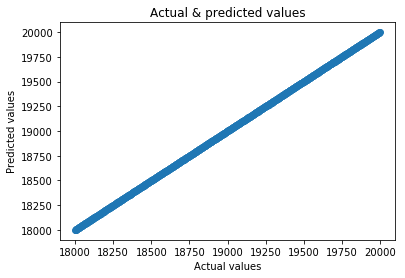

In [22]:
plt.scatter(result, test_labels)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual & predicted values')
plt.show()